---
title: "DATA210P HW2 - Bike Sharing (hour.csv): Linear Modeling, Selection, Validation, and Ridge & Lasso"
author: "Joe Nguyen, Haesung Becker, Jared Lyon, Tao Chen"
format:
  pdf:
    number-sections: true
    fig-pos: "H"
    toc: true
    toc-depth: 3
    df-print: pandas
    keep-tex: true
    geometry:
    - margin=1in
    header-includes:
      - \KOMAoption{captions}{tableheading}
      - \usepackage{textcomp}
execute:
  echo: false
  warning: false
  message: false
fig-width: 8
fig-height: 5
dpi: 300
---

\newpage

# Project Overview

## Libraries & packages

In [6]:
#| echo: true

# Standard library imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Third-party imports
from dataclasses import dataclass
from typing import Callable, Dict, Optional, Tuple, List, Any
from textwrap import dedent
import patsy

# Statsmodels imports
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.gofplots import qqplot
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.stats.diagnostic import het_breuschpagan

# Sklearn imports
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, Ridge, Lasso, lasso_path

# Set global configurations
np.random.seed(42)
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)

## Data Source & Import:

Import UCI ML Repo and load dataset (hour.csv). We decided to use the hour.csv dataset for this homework assignment because it contains a larger sample size and time-of-day effects for a more robust analysis.

In [7]:
from ucimlrepo import fetch_ucirepo 
  
# Fetch dataset 
bike_sharing = fetch_ucirepo(id=275) 
  
# Separate predictors and response
X = bike_sharing.data.features 
y = bike_sharing.data.targets 

## Data Dictionary:
From data source:

1) **Outcome (Response) Variable**: cnt (integer) - count of total rental bikes including both casual and registered

2) **Predictor (Feature) Variables**:
    - instant (integer) - record index
    - dteday (date) - date
    - season (categorical) - season (1:winter, 2:spring, 3:summer, 4:fall)
    - yr (categorical) - year (0: 2011, 1:2012)
    - mnth (categorical) - month (1 to 12)
    - hr (categorical) - hour (0 to 23)
    - holiday (binary) - whether the day is a holiday or not
    - weekday (categorical) - day of the week
    - workingday (binary) - if day is neither weekend nor holiday is 1, otherwise is 0.
    - weathersit (categorical) - 
        - 1: Clear, Few clouds, Partly cloudy
        - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
        - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
        - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
    - temp (continuous) - Normalized temperature in Celsius. The values are dervied via (t - t_min)/(t_max - t_min), where t_min=-8, t_max=39 (only in hourly scale)
    - atemp (continuous) - Normalized feeling temperature in Celsius. The values are derived via (t - t_min)/(t_max - t_min), where t_min=-16, t_max=50 (only in hourly scale)
    - hum (continuous) - Normalized humidity. The values are divided to 100 (max)
    - windspeed (continuous) - Normalized wind speed. The values are divided to 67 (max)
    - casual (integer) - count of casual users
    - registered (integer) - count of registered users

Initialize dataframe and perform initial data exploration:

In [8]:
#| label: tbl-df-shape
#| tbl-cap: "Shape and Columns of Data Frame."
#| echo: false

df = X.copy()
df = df.join(y)

print("Shape: ", df.shape)

import textwrap

cols_str = ", ".join(map(str, df.columns))
wrapped = textwrap.fill(cols_str, width=80)

print("Columns:")
print(wrapped)



Shape:  (17379, 14)
Columns:
dteday, season, yr, mnth, hr, holiday, weekday, workingday, weathersit, temp,
atemp, hum, windspeed, cnt


## Initial Exploratory Data Analysis (EDA) with Visualization

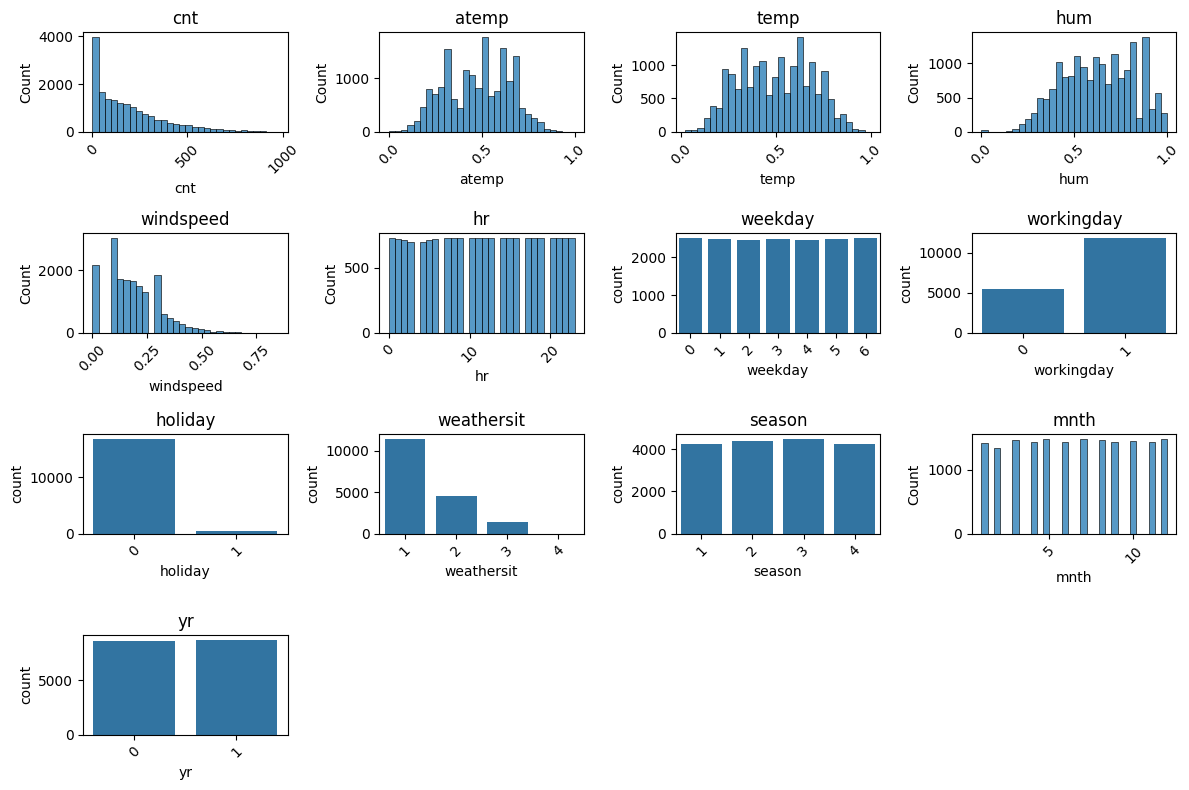

In [9]:
#| label: fig-distributions
#| fig-cap: "Distributions of continuous and categorical predictors."
#| fig-width: 8
#| fig-height: 6

# Removed dteday (raw date) and cnt (response)
vars_to_plot = [
    "cnt",
    "atemp",
    "temp",
    "hum",
    "windspeed",
    "hr",
    "weekday",
    "workingday",
    "holiday",
    "weathersit",
    "season",
    "mnth",
    "yr"
]

n_cols = 4
n_rows = int(np.ceil(len(vars_to_plot) / n_cols))

plt.figure(figsize=(12, 8))

for i, var in enumerate(vars_to_plot, 1):
    plt.subplot(n_rows, n_cols, i)
    
    if df[var].dtype.name == "category" or df[var].nunique() < 10:
        sns.countplot(x=df[var])
    else:
        sns.histplot(df[var], bins=30, kde=False)
    
    plt.title(var)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


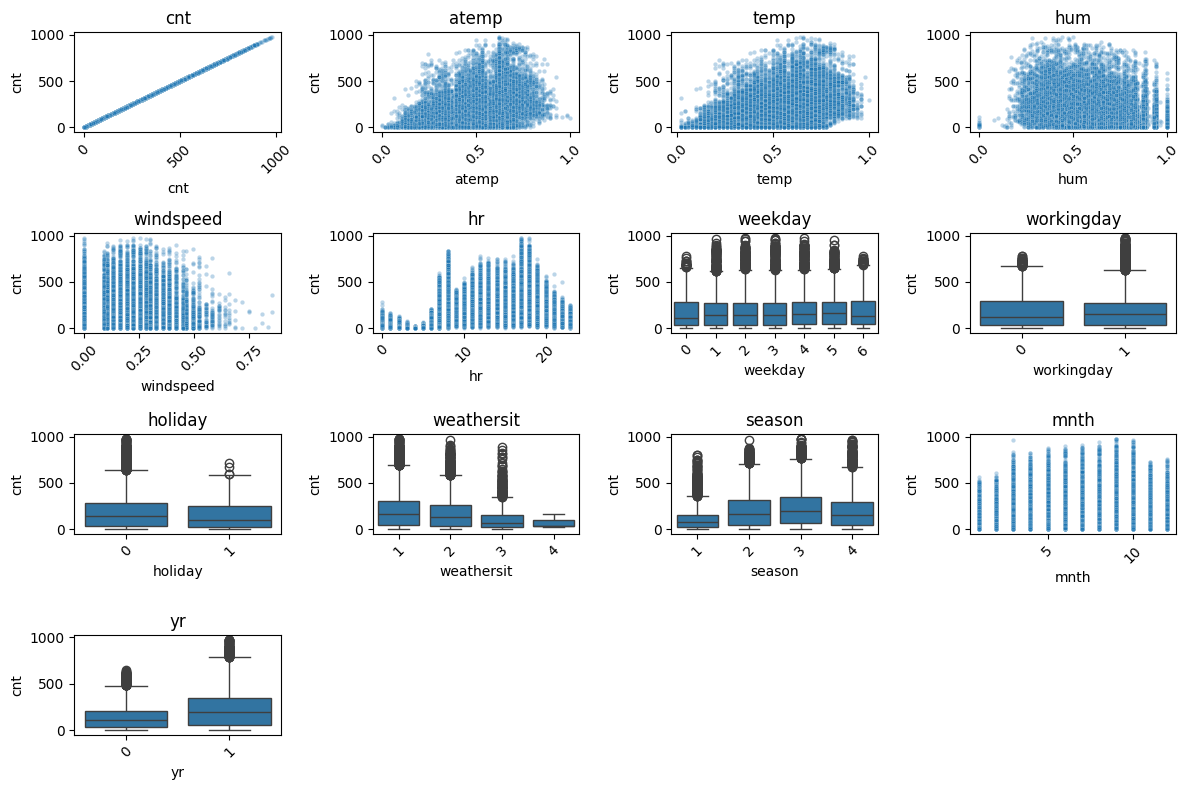

In [10]:
#| label: fig-predictor-vs-cnt
#| fig-cap: "Relationships between predictors and hourly bike rentals (cnt)."
#| fig-width: 8
#| fig-height: 4
#| echo: false

plt.figure(figsize=(12, 8))

for i, var in enumerate(vars_to_plot, 1):
    plt.subplot(n_rows, n_cols, i)
    
    if df[var].dtype.name == "category" or df[var].nunique() < 10:
        sns.boxplot(x=df[var], y=df["cnt"])
    else:
        sns.scatterplot(x=df[var], y=df["cnt"], alpha=0.3, s=10)
    
    plt.title(var)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


# Linear Model and Interpretation

## Predictor selection and justification

After careful consideration from our initial EDA in @fig-distributions and @fig-predictor-vs-cnt , we've decided to break down the predictor selection into several categories to fit into the baseline OLS model while excluding the variables that may lead to redundancy or multicollinearity (#4):

1) **Calendar Variables**: hr, weekday, workingday, holiday
   - These variables capture the time-related patterns in bike rentals.   

2) **Seasonal Variables**: season, yr
   - Seasonal trends and yearly changes can significantly impact bike rental behavior.

3) **Weather Variables**: weathersit, temp, hum, windspeed
   - Weather conditions significantly influence bike rental behavior and demand. 

4) **Exclusion of leakage Variables**: dteday, atemp, mnth
   - The variable atemp is highly collinear with temp and doesn't much predictive power beyond temp. Similar, mnth is highly collinear to season and possibly temp.

Additionally, we've also broken them down into specific data types for clarity:

1) **Categorical Variables**: season, yr, mnth, hr, holiday, weekday, workingday, weathersit
   - These variables represent distinct categories or groups.
   
2) **Continuous Variables**: temp, hum, windspeed
   - These variables represent measurable quantities that can take on a wide range of values.

## Fit and show results of OLS model

@tbl-ols-fit summarizes the baseline model fit statistics whereas @tbl-ols-coef provides a coefficient table that's sorted for lowest p-values.

In [ ]:
# Baseline OLS model
#| echo: true
baseline_formula = dedent("""
cnt ~ temp + hum + windspeed
    + C(weathersit)
    + C(hr)
    + C(weekday)
    + workingday
    + holiday
    + C(season)
    + C(yr)
""").strip()

In [12]:
#| label: tbl-ols-fit
#| tbl-cap: "Baseline OLS model fit statistics."

# Fit OLS model & print summary
ols_baseline = smf.ols(formula=baseline_formula, data=df).fit()
print("\n--- Statsmodels Summary ---\n")
print(ols_baseline.summary())


--- Statsmodels Summary ---

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                     929.0
Date:                Fri, 30 Jan 2026   Prob (F-statistic):               0.00
Time:                        01:01:48   Log-Likelihood:            -1.0509e+05
No. Observations:               17379   AIC:                         2.103e+05
Df Residuals:                   17338   BIC:                         2.106e+05
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Interc

In [ ]:
#| label: tbl-ols-coef
#| tbl-cap: "Baseline OLS model fit coefficient table."

# Coefficient table (estimate, SE, p-value, CI)
coef_tbl = pd.DataFrame({
    "term": ols_baseline.params.index,
    "estimate": ols_baseline.params.values,
    "std_err": ols_baseline.bse.values,
    "p_value": ols_baseline.pvalues.values
})

# Confidence intervals
conf_int = ols_baseline.conf_int()
conf_int.columns = ["conf_low", "conf_high"]

# Merge confidence intervals into coefficient table
coef_tbl = coef_tbl.merge(conf_int.reset_index().rename(columns={"index": "term"}), on="term", how="left")

# Sort by p-value
coef_tbl = coef_tbl.sort_values("p_value", ascending=True).reset_index(drop=True)

print("\n--- Coefficient Table ---\n")
print(coef_tbl)


--- Coefficient Table ---

                  term      estimate       std_err        p_value      conf_low     conf_high
0           C(hr)[T.8]  3.109038e+02  5.379574e+00   0.000000e+00  3.003593e+02  3.214483e+02
1          C(hr)[T.18]  3.464628e+02  5.470435e+00   0.000000e+00  3.357402e+02  3.571854e+02
2          C(hr)[T.19]  2.376637e+02  5.428111e+00   0.000000e+00  2.270241e+02  2.483034e+02
3          C(hr)[T.16]  2.247619e+02  5.525528e+00   0.000000e+00  2.139313e+02  2.355925e+02
4          C(hr)[T.17]  3.783610e+02  5.499041e+00   0.000000e+00  3.675824e+02  3.891397e+02
5           C(yr)[T.1]  8.548581e+01  1.568613e+00   0.000000e+00  8.241117e+01  8.856045e+01
6                 temp  2.449964e+02  7.110919e+00  1.136117e-251  2.310583e+02  2.589345e+02
7          C(hr)[T.12]  1.740695e+02  5.474718e+00  1.127114e-215  1.633385e+02  1.848005e+02
8           C(hr)[T.7]  1.702513e+02  5.382477e+00  1.567761e-213  1.597011e+02  1.808015e+02
9          C(hr)[T.13]  1.691885

## Interpretation of coefficients

Before we begin, all interpretations for the individual variables below assume that we are **holding all other variables constant** and that **cnt is bike rentals per hour** since we're using the hour.csv dataset. Out of the 10 variables fitted into the model, we've selected 7 variables to interpret. Among them are 3 continuous weather variables with strongly supported effects, 1 encoded categorical variable to discuss the referencing, 2 calendar variables with unstable and unsupported effects with potential multicollinearity issues, and the hour variable enabled by hour.csv to demonstrate its analytical value. The exclusion of the other 3 variables (weekday, season, and yr) does not simply that they're not important to our analysis and will be accounted for in our analysis in later sections. 

Our interpretations of the selected coefficients from the baseline OLS model are as follows:

1) Continuous Weather Variables:
   - **Temperature (temp)**: From @tbl-ols-coef, a one-unit increase in normalized temperature (temp) is associated with an increase of approximately 233.3 additional bike rentals per hour on average. The data strongly rejects the null hypothesis of no effect (p < 0.001) and the 95% confidence interval (CI): [215, 252]. This suggests that warmer temperatures may potentially encourage more bike rentals.

   - **Humidity (hum)**: From @tbl-ols-coef, a one-unit increase in normalized humidity (hum) is associated with a decrease of approximately 81.3 fewer bike rentals per hour on average. The data strongly rejects the null hypothesis of no effect (p < 0.001) and the 95% CI: [-70, -92]. This indicates that higher humidity levels may deter people from renting bikes.

   - **Windspeed (windspeed)**: From @tbl-ols-coef, a one-unit increase in normalized windspeed (windspeed) is associated with a decrease of approximately 36.3 fewer bike rentals per hour on average. The data strongly rejects the null hypothesis of no effect (p < 0.001) and the 95% CI:[-23, -50]. This suggests that windier conditions may discourage bike rentals.

2) Categorical Weather Variable:
    - **Weather Situation (weathersit)**: From @tbl-ols-coef, the top 2 weather situations are weathersit 3 (T.3) and 2 (T.2) in terms of the strength of the statistical evidence supporting an association with hourly bire rentals. However, note that the categorical coefficients of T.3 and T.2 are relative to the reference weather situation (T.1 or clear/few clouds/partly cloudly). T.2 or misty/cloudy weather is associated with approximately 10.7 fewer bike rentals per hour on average compared to clear weather (T.1). Similarly, T.3 or light rain/snowy weather is associated with approximately 65.9 fewer bike rentals per hour on average compared to clear weather with a 95% CI:[-60, -73]. Both effects are supported by strong statistical evidence in the data (p < 0.001). This potentially highlights the negative impact of adverse weather conditions on bike rental demand.

3) Calendar & Human Behavior Variables:
   - **Holiday (holiday)**: From @tbl-ols-coef, the model estimates that holidays are associated with a decrease of approximately 2.47e+13 bike rentals compared to to the baseline reference of non-holidays which is huge and unstable. In this case, the data does not support rejecting the null hypothesis of no effect (p = 0.998) with an extremely wide 95% CI:[-1.68e+14, 2.18e+14] spanning large negative and positive values - indicating that the model cannot reliably determine the effect and its direction.

   - **Working Day (workingday)**: From @tbl-ols-coef, the model also estimates that working day is associated with a decrease of approximately bike rentals per hour compared to non-working days. Similarly to holidays, this estimate is not statistically supported (p = 0.978) with an implausibly large estimated coefficient of 2.47e+13 and the 95% CI (-1.68e+14, 2.18e+14) is extremely wide. This suggests that the model cannot reliably determine the effect of working days on bike rentals.
   
   **NOTE:** Not only are the holiday and workingday variables not statistically supported in this model, their estimated coefficients are exactly the same indicating potential multicollinearity between these two variables. This is likely due to the fact that non-working days are holidays and weekends. We should expect an inverse relationship between workingday and holiday.

   - **Hour of the Day (hr)**: From @tbl-ols-coef, we observe that certain hours (e.g., T.8 (8am) and T.16-19 (4-7pm)) dominates the significance levels (p-values) among the top 5. However, we need to be careful in interpreting these coefficients as they are relative to the reference hour (midnight-1am). For example, T.8 has a coefficient of approximately +310.9 with a 95% CI: [300, 321], indicating that bike rentals (cnt) increase significantly during this hour compared to midnight, likely due to morning commute patterns. In @fig-hr-effects, we can see the peaks during typical commuting hours (8am and 5pm), suggesting that people are more likely to rent bikes during these times for commuting purposes.


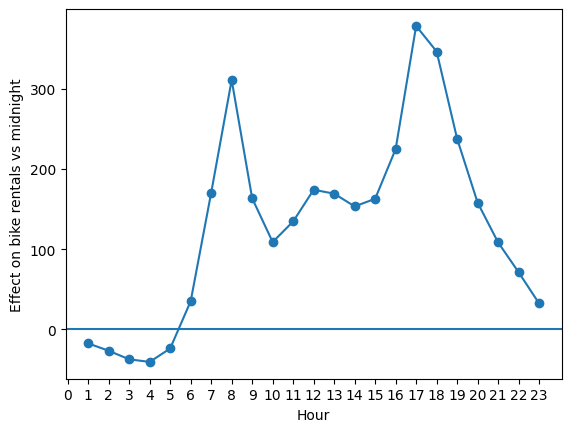

In [14]:
#| label: fig-hr-effects
#| fig-cap: "Estimated hour-of-day effects relative to the reference hour (midnight/ hr=0)."
#| fig-width: 8
#| fig-height: 4

# Extract hour terms from coefficient table
hr_terms = coef_tbl[coef_tbl["term"].str.contains(r"^C\(hr\)\[T\.", regex=True)].copy()
hr_terms["hour"] = hr_terms["term"].str.extract(r"\[T\.(\d+)\]").astype(int)

# Sort by hour
hr_terms = hr_terms.sort_values("hour").reset_index(drop=True)

# Select relevant columns
hr_terms[["hour", "estimate", "std_err", "p_value", "conf_low", "conf_high"]]

# Plot hour effects based on estimates (coefficients)
plt.figure()
plt.plot(hr_terms["hour"], hr_terms["estimate"], marker="o")
plt.axhline(0)
plt.xlabel("Hour")
plt.ylabel("Effect on bike rentals vs midnight")
plt.xticks(range(0, 24))
plt.show()

## Significance vs. practical importance

In @tbl-ols-coef , we observe many predictors in the baseline OLS model exhibit strong statistical evidence of association with hourly bike rentals (cnt). However, this does not imply practical importance. Given the large sample size  of the hourly dataset (n = 17,379), even **relatively small effects can achieve extremely low p-values**. As a result, p-values in this context primarily reflect the precision and consistency of the estimates rather than the magnitude of the effects.

To assess practical importance, we should consider the actual effect sizes (coefficients) alongside their **95% confidence intervals and their real-world implications**. For example, hour of the day (hr) and temperature (temp) both show overwhelming statistical support and large, meaninful effects. During peak commute hours as shown in @fig-hr-effects, bike rentals increase by several hundred bikes per hour compared to the baseline hour (midnight). Similarly, temperature also show substantial effects on hourly bike rentals, with warmer temperatures leading to significant increases in rentals. Other weather variables like humidity, windspeed, and weather situation also show meaningful effects, although smaller in magnitude. 

In contrast, a select few calendar-based variables carry **unstable estimated coefficients and wide confidence intervals** e.g., workingday with a 95% CI: [-1.69e+14, 2.18e+14] suggest that, under the current model, do not contribute reliably to explaining variation in hourly bike rentals. Although not discussed in our interpretation, the categorical variable C(weathersit)[T.4] or severe weather show a p-value of 0.234 and a 95% CI: [-186.65, 45.64] indicating uncertain direction. Conceptually, severe weather should reduce demand, however, from @fig-distributions, we can observe that weathersit = 4 is very rare in the dataset. Despite being conceptually practical, this is another example of a variable being impractical for inference in our model likely due to the data sparsity.

In summary, this analysis highlights the **importance of interpreting statistical significance alongside effect magnitude, direction, and conceptual relevance**, rather than relying on p-values or any one metric alone. To improve our analysis and the model's predictive and inferential performance, further model diagnostics, transformations, and validation techniques will be considered below.

# Transformations and Model Diagnostics

## Baseline OLS Model diagnostics

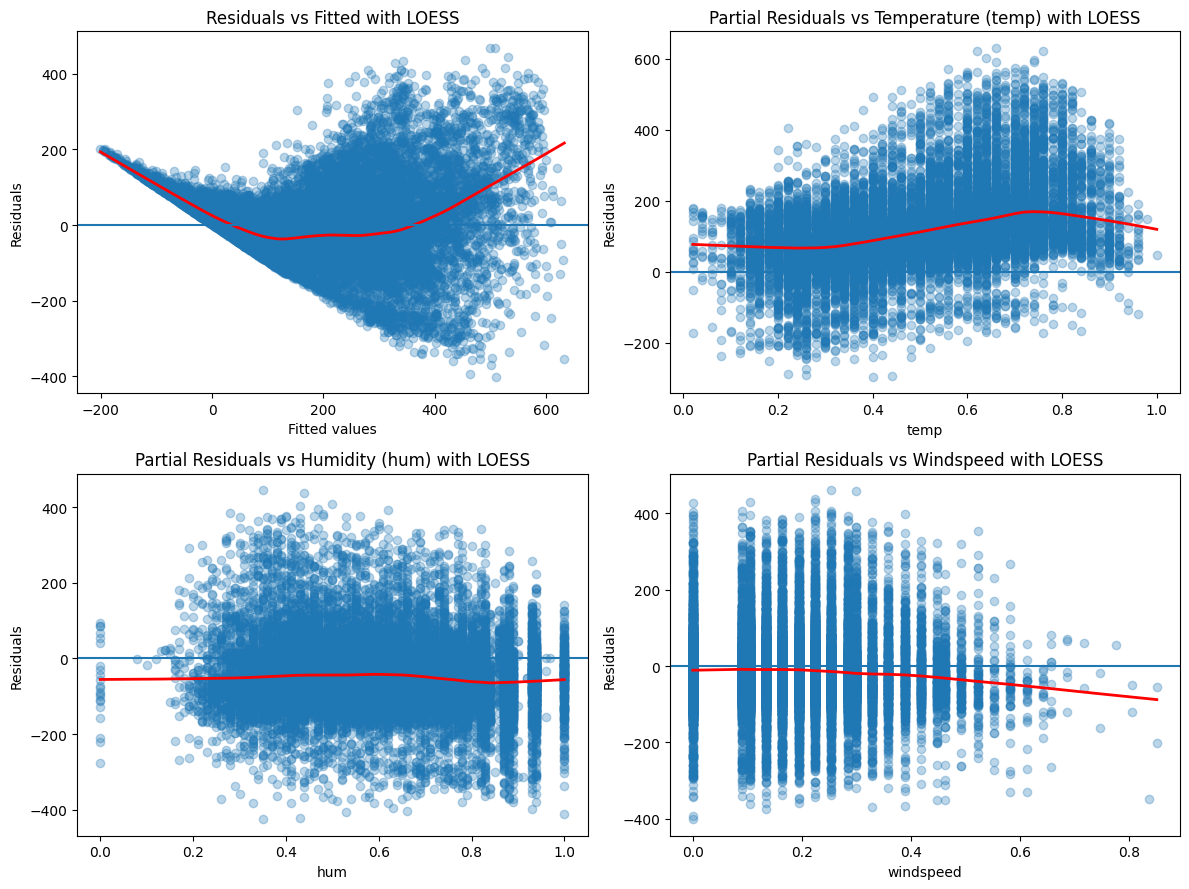

In [15]:
#| label: fig-residual-diagnostics-baseline-ols
#| fig-cap: "Residual diagnostics for the baseline OLS model."
#| fig-width: 9
#| fig-height: 7
#| echo: false

fitted = ols_baseline.fittedvalues
resid = ols_baseline.resid

fig, axes = plt.subplots(2, 2, figsize=(12, 9))

# Compute LOWESS smoother
lowess_fit = lowess(resid, fitted, frac=0.3)

# Residuals vs fitted
axes[0, 0].scatter(fitted, resid, alpha=0.3)
axes[0, 0].plot(lowess_fit[:, 0], lowess_fit[:, 1], color="red", linewidth=2)
axes[0, 0].axhline(0)
axes[0, 0].set_title("Residuals vs Fitted with LOESS")
axes[0, 0].set_xlabel("Fitted values")
axes[0, 0].set_ylabel("Residuals")

# Residuals vs temp
beta_temp = ols_baseline.params["temp"]
partial_resid_temp = beta_temp * df["temp"] + resid
lowess_temp = lowess(partial_resid_temp, df["temp"], frac=0.3)
axes[0, 1].scatter(df["temp"], partial_resid_temp, alpha=0.3)
axes[0, 1].plot(lowess_temp[:, 0], lowess_temp[:, 1], color="red", linewidth=2)
axes[0, 1].axhline(0)
axes[0, 1].set_title("Partial Residuals vs Temperature (temp) with LOESS")
axes[0, 1].set_xlabel("temp")
axes[0, 1].set_ylabel("Residuals")

# Residuals vs humidity
beta_hum = ols_baseline.params["hum"]
partial_resid_hum = beta_hum * df["hum"] + resid
lowess_hum = lowess(partial_resid_hum, df["hum"], frac=0.3)
axes[1, 0].scatter(df["hum"], partial_resid_hum, alpha=0.3)
axes[1, 0].plot(lowess_hum[:, 0], lowess_hum[:, 1], color="red", linewidth=2)
axes[1, 0].axhline(0)
axes[1, 0].set_title("Partial Residuals vs Humidity (hum) with LOESS")
axes[1, 0].set_xlabel("hum")
axes[1, 0].set_ylabel("Residuals")

# Residuals vs windspeed
beta_windspeed = ols_baseline.params["windspeed"]
partial_resid_windspeed = beta_windspeed * df["windspeed"] + resid
lowess_windspeed = lowess(partial_resid_windspeed, df["windspeed"], frac=0.3)
axes[1, 1].scatter(df["windspeed"], partial_resid_windspeed, alpha=0.3)
axes[1, 1].plot(lowess_windspeed[:, 0], lowess_windspeed[:, 1], color="red", linewidth=2)
axes[1, 1].axhline(0)
axes[1, 1].set_title("Partial Residuals vs Windspeed with LOESS")
axes[1, 1].set_xlabel("windspeed")
axes[1, 1].set_ylabel("Residuals")

plt.tight_layout()
plt.show()


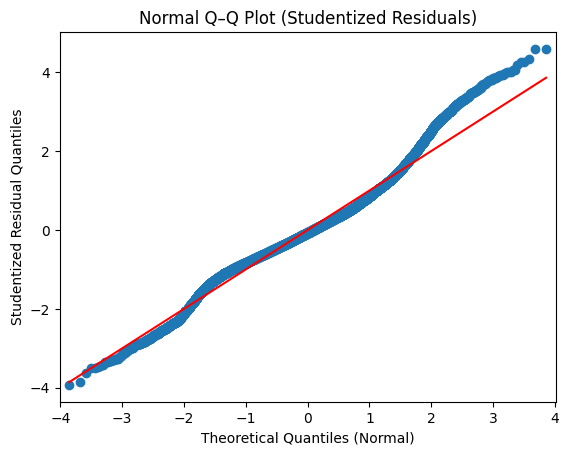

In [16]:
#| label: fig-qq-plot-baseline-ols
#| fig-cap: "Normal Q–Q plot of studentized residuals from the baseline OLS model."
#| fig-width: 5
#| fig-height: 5
#| echo: false

# Studentized residuals
influence = ols_baseline.get_influence()
rstudent = influence.resid_studentized_internal

# Q–Q plot
sm.qqplot(rstudent, line="s")
plt.xlabel("Theoretical Quantiles (Normal)")
plt.ylabel("Studentized Residual Quantiles")
plt.title("Normal Q–Q Plot (Studentized Residuals)")
plt.show()


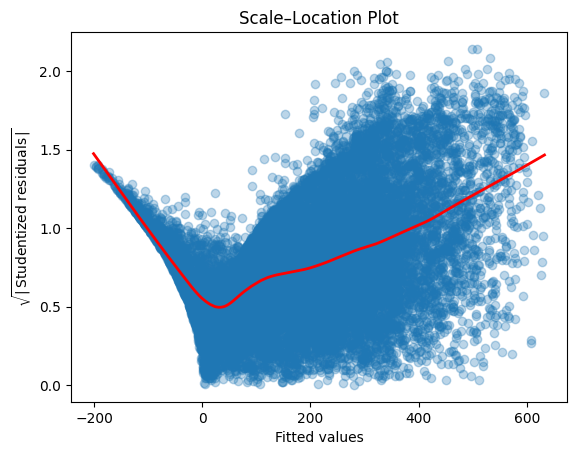

In [17]:
#| label: fig-scale-location-baseline-ols
#| fig-cap: "Scale–location plot of studentized residuals for the baseline OLS model."
#| fig-width: 5
#| fig-height: 4
#| echo: false

# Fitted values
fitted = ols_baseline.fittedvalues

# Studentized residuals
influence = ols_baseline.get_influence()
rstudent = influence.resid_studentized_internal

# Scale–location values
sqrt_abs_rstudent = np.sqrt(np.abs(rstudent))

# LOWESS smoother
lowess_sl = lowess(sqrt_abs_rstudent, fitted, frac=0.3, return_sorted=True)

plt.figure()
plt.scatter(fitted, sqrt_abs_rstudent, alpha=0.3)
plt.plot(lowess_sl[:, 0], lowess_sl[:, 1], color="red", linewidth=2)
plt.xlabel("Fitted values")
plt.ylabel(r"$\sqrt{|\,\text{Studentized residuals}\,|}$")
plt.title("Scale–Location Plot")
plt.show()


In [18]:
#| label: tbl-breusch-pagan-baseline-ols
#| tbl-cap: "Breusch–Pagan test for heteroskedasticity in the baseline OLS model."
#| echo: false

bp_test = het_breuschpagan(resid, ols_baseline.model.exog)

bp_results = pd.Series(
    bp_test,
    index=["LM Statistic", "LM p-value", "F Statistic", "F p-value"]
)

bp_results

LM Statistic    5504.267929
LM p-value         0.000000
F Statistic      200.916107
F p-value          0.000000
dtype: float64

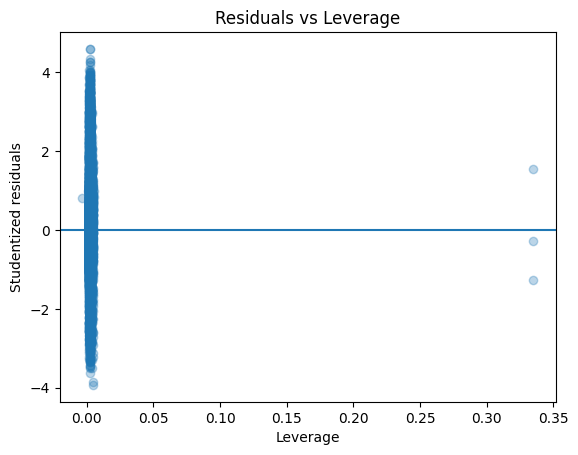

In [554]:
#| label: fig-residuals-vs-leverage-baseline-ols
#| fig-cap: "Studentized residuals versus leverage for the baseline OLS model."
#| fig-width: 6
#| fig-height: 5
#| echo: false

influence = ols_baseline.get_influence()
leverage = influence.hat_matrix_diag
rstudent = influence.resid_studentized_internal

plt.figure()
plt.scatter(leverage, rstudent, alpha=0.3)
plt.axhline(0)
plt.xlabel("Leverage")
plt.ylabel("Studentized residuals")
plt.title("Residuals vs Leverage")
plt.show()


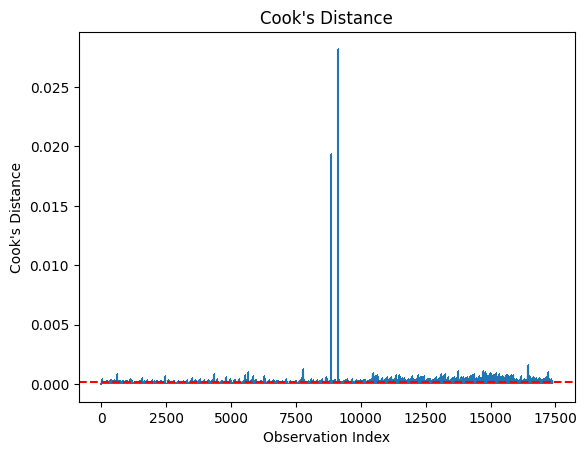

In [555]:
#| label: fig-cooks-distance-baseline-ols
#| fig-cap: "Cook’s distance for the baseline OLS model."
#| fig-width: 7
#| fig-height: 4
#| echo: false

influence = ols_baseline.get_influence()
cooks_d = influence.cooks_distance[0]

plt.figure()
plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",", basefmt=" ")
plt.axhline(4 / len(cooks_d), linestyle="--", color="red")
plt.xlabel("Observation Index")
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance")
plt.show()


From our diagnostic plots above, we can visually and numerically evaluate our baseline OLS model's assumptions as follows: 

With respect to linearity in @fig-residual-diagnostics-baseline-ols, there is a U-shaped curvature in the LOESS line in the Residuals vs. Fitted plot indicating **systematic departures from linearity** in the overall mean function indicating global nonlinearity at low and high fitted values. This could lead to prediction bias, misleading coefficients, and unreliable statistical inference. As a result, these issues motivate the consideration of transformations or alternative modeling approaches that better capture nonlinear relationships.

In further analysis, we plotted the 3 continuous predictors (temp, hum, and windspeed) against their respective partial residuals in @fig-residual-diagnostics-baseline-ols. When plotted using the partial residuals vs temperature (temp), the LOESS line has mild slope changes at low and high temperatures, suggesting the **linearity assumption is not violated**. Similarly for humidity (hum) and windspeed, we observe no significant curvatures that would hint at nonlinearity other than mild curvatures at the tails. 

In @fig-qq-plot-baseline-ols for checking normality, using the studentized residuals, the normal Q-Q plot shows that while most of the distribution is approximately normal, there is clear departures occuring at the upper tail. This suggests **heavy-tailed errors and a violation of the normality assumption** and that our p-values and CIs may not be reliable for inference. Once again, another motivation for transformations or alternative modeling methods.

In @fig-scale-location-baseline-ols for validating homoskedasticity, we observe a funnel shape in which studentized residual spread as fitted values increase. The lower tail is sharply bounded whereas the upper tail grows. This observation hints at **heteroskedasticity and our assumption of constant residual variance is violated**. This motivates further variance-stabilizing transformations. **Supported by the Breusch-Pagan test** in @tbl-breusch-pagan-baseline-ols with a p-value < 0.05 i.e., there is strong support in rejecting the null hypothesis of homoskedasticity - there's evidence of heteroskedasticity.

In @fig-residuals-vs-leverage-baseline-ols for confirming leverage and influence in observations, there are a small number of observations with high leverage and moderate studentized residuals whereas the rest of the dataset remain small and well below thresholds associated with undue influence. Consistent with @fig-cooks-distance-baseline-ols, only two observations with high leverage and moderate residual show up as high influence on Cook's D near 0.02 and 0.025 which are very minimal in comparison to the 0.5 threshold that would be of concern. As a result, there's **no evidence that the fitted model is overly sensitive to any small number of influential observations**.


## Transformations

To address the assumption violations above, we chose to apply a **log transformation to the response variable (cnt)**. In our early EDA, we observed that cnt has a heavily skewed right-tail as observed in @fig-distributions. Additionally, this transformation is also motivated by the presence of heteroskedasticity, heavy-tailed residuals, and global nonlinearity in the baseline OLS model. The log transformation should stabilize the variance and reduce the influence of extreme outliers. A constant of one is added to accomodate for zero counts.

**Important note:** the log transformation changes our interpretation of estimated coefficients to **approximate percent change in hourly bike rentals**.

In [22]:
# Create log_cnt with log transform cnt
df["log_cnt"] = np.log(df["cnt"] + 1)

## Refit model and compare

In [23]:
#| label: tbl-ols-baseline-vs-log-metrics
#| tbl-cap: "In-sample model comparison metrics for the baseline and log-transformed OLS models."
#| echo: false

# Replace cnt with log_cnt & refit OLS as ols_log
log_formula = baseline_formula.replace("cnt", "log_cnt")
ols_log = smf.ols(log_formula, data=df).fit()

# Compare baseline vs. log table
pd.DataFrame({
    "Model": ["Baseline OLS", "Log-Transformed OLS"],
    "Adj_R^2": [ols_baseline.rsquared_adj, ols_log.rsquared_adj],
    "AIC": [ols_baseline.aic, ols_log.aic],
    "BIC": [ols_baseline.bic, ols_log.bic]
})


,Model,Adj_R^2,AIC,BIC
0,Baseline OLS,0.681128,210260.540315,210578.824047
1,Log-Transformed OLS,0.825787,31126.973333,31445.257065


Our model comparison includes in-sample (data seen) and out-of-sample (data unseen) metrics. In-sample statistics such as adjusted R^2, AIC, and BIC provide descriptive measures of fit for their respective response scales (baseline vs. log-transformed OLS). In @tbl-ols-baseline-vs-log-metrics, the log-transformed model has a substantially higher adjusted R^2 indicating **improved explanatory power** i.e., closer fit to the observed data, but not a definitive improvement in fit from the original scale. 

Whereas the large decrease in AIC and BIC values, this tells us that the log-transformed model improved in-sample likelihood fit i.e., the **model's assumptions about noise and stability match the data better** - likely due to improved normality and stabilizing residual variance.

In contrast, the out-of-sample evaluation using k-fold cross-validated RMSE is **deferred to part IV** and will serve as the primary criterion for predictive performance and model selection. 

# Collinearity Assessment

## Correlation matrix with numeric predictors

In [558]:
#| label: tbl-corr-numeric-predictors
#| tbl-cap: "Correlation matrix for numeric predictors."
#| echo: false

numeric_vars = ["temp", "hum", "windspeed"]
corr_tbl = df[numeric_vars].corr()

print(corr_tbl)


               temp       hum  windspeed
temp       1.000000 -0.069881  -0.023125
hum       -0.069881  1.000000  -0.290105
windspeed -0.023125 -0.290105   1.000000


## VIF analysis

In [593]:
#| label: tbl-vif-log-ols
#| tbl-cap: "Top 15 Variance Inflation Factors (VIF) for predictors in the log-transformed OLS model."
#| echo: false

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning,
                        module="statsmodels.stats.outliers_influence")

X_log = ols_log.model.exog
vif_log = pd.DataFrame({
    "variable": ols_log.model.exog_names,
    "VIF": [variance_inflation_factor(X_log, i) for i in range(X_log.shape[1])]
})

# Drop intercept
vif_log = vif_log[vif_log["variable"] != "Intercept"]

vif_log.sort_values("VIF", ascending=False).head(15)



,variable,VIF
30,C(weekday)[T.4],inf
31,C(weekday)[T.5],inf
27,C(weekday)[T.1],inf
29,C(weekday)[T.3],inf
28,C(weekday)[T.2],inf
41,holiday,inf
40,workingday,inf
34,C(season)[T.3],4.228093
37,temp,3.105377
33,C(season)[T.2],2.498219


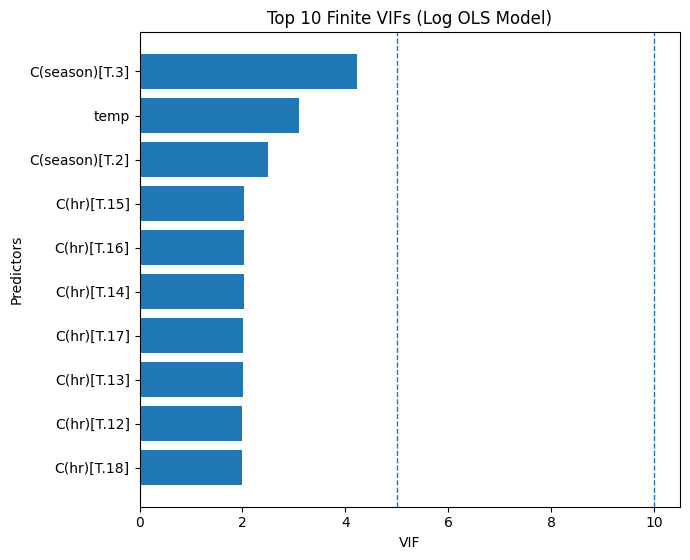

In [581]:
#| label: fig-vif-log-ols-top10-finite
#| fig-cap: "Top finite variance inflation factors (VIF) for predictors in the log-transformed OLS model. Predictors with infinite VIF arise from exact multicollinearity among dummy-encoded categorical variables and are omitted from this plot."
#| fig-width: 7
#| fig-height: 5
#| echo: false

v = (
    vif_log
    .replace([np.inf, -np.inf], np.nan)
    .dropna(subset=["VIF"])
    .sort_values("VIF", ascending=False)
)

N = min(10, len(v))
v_top = v.head(N).sort_values("VIF", ascending=True)

plt.figure(figsize=(7, 0.45 * N + 1.2))
plt.barh(v_top["variable"], v_top["VIF"])
plt.axvline(5, linestyle="--", linewidth=1)
plt.axvline(10, linestyle="--", linewidth=1)
plt.title(f"Top {N} Finite VIFs (Log OLS Model)")
plt.ylabel("Predictors")
plt.xlabel("VIF")
plt.tight_layout()
plt.show()


## Discussion of collinearity effects

In @tbl-corr-numeric-predictors, the correlation matrix among numerically continous predictors (temp, hum, and windspeed) indicates no strong pairwise linear relationships. While humidity and windspeed show a modest negative association (~ -0.29), none of the absolute correlation values approach problematic levels for collinearity (e.g., |p| > 0.7).

In @tbl-vif-log-ols, VIF values are reported in descending order. Several categorical and binary variables with **inf VIF values indicate perfect multicollinearity or exact linear combinations** of one another once encoding is applied e.g., workingday is defined by weekday and holiday with overlapping calendar information. The remaining variables as shown in @fig-vif-log-ols-top10-finite are considered in moderate VIF values (~ 2-5) or low values (<= 1) without raising concerns for multicollinearity. However, it's important to highlight the potential collinearity between season and temp at the top of the list. Since temperature changes with the season, these two variables are likely to provide overlapping information. Something we will explore more in section IV.3 for model selection.

As a result, calendar-related categorical and binary variables with perfect multicollinearity, due to overlapping definitions, can lead to **variance inflation of standard errors and complicated coefficient interpretations** as discusses in section I.4. Although collinearity complicates interpretability and statistical inference, it **does not necessarily harm predictive performance** because predictions depend on combined linear predictors with redundant variables that may jointly capture meaningful structure in the data.

Several strategies can be used to address collinearity, depending on **whether the primary goal is interpretability or predictive performance**. Common strategies include:
1) Remove redundant predictors: remove workingday and keep weekday & holiday to improve interpretation
2) Redesign variable encodings: represent calendar effects solely with weekday indicators
3) Combine correlated variables: temp_index = (temp + atemp) / 2
4) Apply regularization techniques: Ridge or Lasso to preserve predictive performance

# Model Selection and Validation

## Cross-validation & Utilities Setup

Here, we define 3 functions to leverage in model selection and validation.

1) cv_metric_formula: to calculate MSE or RMSE given the parameters (nested inside stepwise_selection_cv)

2) stepwise_selection_cv: to conduct stepwise selection cross-validation based on RMSE or MSE as primary criterion

3) stepwise_selection_aic_bic: to conduct stepwise selection cross-validation based on AIC or BIC as primary criterion

In [20]:
# | echo: false

# Define K-fold CV metric function (RMSE or MSE)
def cv_metric_formula(
    formula: str,
    df,
    K: int = 5,
    random_state: int = 42,
    metric: str = "rmse",  # "rmse" or "mse"
) -> tuple[float, float]:
    """
    K-fold CV metric for a statsmodels formula.
    metric: "rmse" (default) or "mse"
    Returns (mean_metric, std_metric).
    """
    metric = metric.lower()
    if metric not in {"rmse", "mse"}:
        raise ValueError("metric must be 'rmse' or 'mse'")

    kf = KFold(n_splits=K, shuffle=True, random_state=random_state)
    vals = []

    for train_idx, test_idx in kf.split(df):
        train = df.iloc[train_idx]
        test  = df.iloc[test_idx]

        model = smf.ols(formula, data=train).fit()

        y_test, _ = patsy.dmatrices(formula, data=test, return_type="dataframe")
        preds = model.predict(test)

        mse = mean_squared_error(y_test.iloc[:, 0], preds)
        val = np.sqrt(mse) if metric == "rmse" else mse
        vals.append(val)

    return float(np.mean(vals)), float(np.std(vals, ddof=1))

# Define stepwise selection for CV (RMSE or MSE)
def stepwise_selection_cv(
    df,
    y: str,
    candidate_terms: list[str],
    K: int = 5,
    random_state: int = 42,
    metric: str = "rmse",
    tol: float = 1e-6,
    max_steps: int | None = None,
    verbose: bool = True,
):
    def make_formula(terms: list[str]) -> str:
        return f"{y} ~ 1" if not terms else f"{y} ~ " + " + ".join(terms)

    included: list[str] = []
    remaining = list(candidate_terms)
    history: list[dict] = []

    best_formula = make_formula(included)
    best_mean, best_std = cv_metric_formula(best_formula, df, K=K, random_state=random_state, metric=metric)

    if verbose:
        print(f"Start: {metric.upper()}={best_mean:.6f} (sd={best_std:.6f}) | {best_formula}")

    steps_taken = 0
    improved = True

    while improved:
        improved = False

        # forward
        forward_best = (best_mean, best_std, None)
        for t in remaining:
            f = make_formula(included + [t])
            m, s = cv_metric_formula(f, df, K=K, random_state=random_state, metric=metric)
            if m < forward_best[0] - tol:
                forward_best = (m, s, t)

        if forward_best[2] is not None:
            t = forward_best[2]
            included.append(t)
            remaining.remove(t)
            best_mean, best_std = forward_best[0], forward_best[1]
            best_formula = make_formula(included)
            steps_taken += 1
            improved = True

            history.append({"action": "add", "term": t, "mean": best_mean, "sd": best_std, "formula": best_formula})
            if verbose:
                print(f"ADD  {t:<20} -> {metric.upper()}={best_mean:.6f} (sd={best_std:.6f})")

            if max_steps is not None and steps_taken >= max_steps:
                break

        # backward
        if len(included) > 0:
            backward_best = (best_mean, best_std, None)
            for t in list(included):
                new_terms = [x for x in included if x != t]
                f = make_formula(new_terms)
                m, s = cv_metric_formula(f, df, K=K, random_state=random_state, metric=metric)
                if m < backward_best[0] - tol:
                    backward_best = (m, s, t)

            if backward_best[2] is not None:
                t = backward_best[2]
                included.remove(t)
                remaining.append(t)
                best_mean, best_std = backward_best[0], backward_best[1]
                best_formula = make_formula(included)
                steps_taken += 1
                improved = True

                history.append({"action": "remove", "term": t, "mean": best_mean, "sd": best_std, "formula": best_formula})
                if verbose:
                    print(f"REM  {t:<20} -> {metric.upper()}={best_mean:.6f} (sd={best_std:.6f})")

                if max_steps is not None and steps_taken >= max_steps:
                    break

    return included, best_mean, best_std, best_formula, history


# For Experimentation: Define stepwise for AIC/BIC criterion
def stepwise_selection_aic_bic(
    df,
    y: str,
    candidate_terms: list[str],
    criterion: str = "aic",
    tol: float = 1e-8,
    verbose: bool = True,
):
    """
    Greedy stepwise selection (both directions) minimizing AIC or BIC
    over *formula terms* (works with numeric + categorical via C(...)).

    Parameters
    ----------
    df : pandas.DataFrame
    y : str
        Response variable name (e.g., "log_cnt")
    candidate_terms : list[str]
        Candidate terms to include/exclude, e.g. ["temp","hum","C(hr)",...]
    criterion : {"aic","bic"}
        Information criterion to minimize
    tol : float
        Minimum improvement required to accept add/remove
    verbose : bool
        Print progress

    Returns
    -------
    selected_terms : list[str]
    best_score : float
    best_formula : str
    history : list[dict]
        Each accepted move with action/add/remove and score.
    """
    crit = criterion.lower()
    if crit not in {"aic", "bic"}:
        raise ValueError("criterion must be 'aic' or 'bic'")

    def make_formula(terms: list[str]) -> str:
        return f"{y} ~ 1" if not terms else f"{y} ~ " + " + ".join(terms)

    def score(terms: list[str]) -> float:
        m = smf.ols(make_formula(terms), data=df).fit()
        return float(m.aic) if crit == "aic" else float(m.bic)

    included: list[str] = []
    remaining = list(candidate_terms)
    history: list[dict] = []

    best_terms = list(included)
    best_score = score(best_terms)

    if verbose:
        print(f"Start: {crit.upper()}={best_score:.6f} | {make_formula(best_terms)}")

    improved = True
    while improved:
        improved = False

        # ---------- Forward step ----------
        add_best_term = None
        add_best_score = best_score

        for t in remaining:
            sc = score(included + [t])
            if sc < add_best_score - tol:
                add_best_score = sc
                add_best_term = t

        if add_best_term is not None:
            included.append(add_best_term)
            remaining.remove(add_best_term)
            best_score = add_best_score
            best_terms = list(included)
            improved = True

            history.append({
                "action": "add",
                "term": add_best_term,
                "score": best_score,
                "formula": make_formula(best_terms),
            })

            if verbose:
                print(f"ADD  {add_best_term:<20} -> {crit.upper()}={best_score:.6f}")

        # ---------- Backward step ----------
        # Try dropping any one included term (after a forward move, or even if none)
        if len(included) > 1:
            drop_best_term = None
            drop_best_score = best_score

            for t in list(included):
                new_terms = [x for x in included if x != t]
                sc = score(new_terms)
                if sc < drop_best_score - tol:
                    drop_best_score = sc
                    drop_best_term = t

            if drop_best_term is not None:
                included.remove(drop_best_term)
                remaining.append(drop_best_term)
                best_score = drop_best_score
                best_terms = list(included)
                improved = True

                history.append({
                    "action": "remove",
                    "term": drop_best_term,
                    "score": best_score,
                    "formula": make_formula(best_terms),
                })

                if verbose:
                    print(f"REM  {drop_best_term:<20} -> {crit.upper()}={best_score:.6f}")

    best_formula = make_formula(best_terms)
    return best_terms, best_score, best_formula, history

## Baseline model CV RMSE results

In [24]:
#| label: tbl-baseline-model-rmse
#| tbl-cap: "RMSE mean and standard deviation for baseline log cnt OLS model."
#| echo: false

mean_rmse_log, std_rmse_log = cv_metric_formula(log_formula, df, K=5)
mean_rmse_log, std_rmse_log
print("Baseline log cnt OLS model RMSE:", mean_rmse_log, "SD:", std_rmse_log)

Baseline log cnt OLS model RMSE: 0.5925789002917841 SD: 0.006101317168347299


## Stepwise selection

In [563]:
#| label: tbl-model-selection-rmse
#| tbl-cap: "Stepwise five-fold cross-validation with Root Mean Squared Error (RMSE) for candidate log-transformed OLS models."
#| echo: false

terms = [
    "temp", "hum", "windspeed",
    "C(weathersit)", "C(hr)", "C(weekday)",
    "workingday", "holiday", "C(season)", "C(yr)"
]

# Stepwise selection CV for RMSE
selected, rmse_mean_val, rmse_sd_val, final_formula, hist = stepwise_selection_cv(
    df, "log_cnt", terms, K=5, metric="rmse", tol=1e-4, max_steps=20, verbose=True
)

print("\nBest formula:", final_formula)
print("RMSE:", rmse_mean_val, "SD:", rmse_sd_val)

ols_selected_rmse = smf.ols(final_formula, data=df).fit()

Start: RMSE=1.417834 (sd=0.014040) | log_cnt ~ 1
ADD  C(hr)                -> RMSE=0.774129 (sd=0.003304)
ADD  temp                 -> RMSE=0.683957 (sd=0.005311)
ADD  C(yr)                -> RMSE=0.643233 (sd=0.005164)
ADD  C(weathersit)        -> RMSE=0.621278 (sd=0.005742)
ADD  C(season)            -> RMSE=0.597358 (sd=0.005879)
ADD  C(weekday)           -> RMSE=0.594297 (sd=0.006039)
ADD  hum                  -> RMSE=0.593732 (sd=0.005565)
ADD  windspeed            -> RMSE=0.593172 (sd=0.005992)
ADD  workingday           -> RMSE=0.592592 (sd=0.006158)

Best formula: log_cnt ~ C(hr) + temp + C(yr) + C(weathersit) + C(season) + C(weekday) + hum + windspeed + workingday
RMSE: 0.5925916101069012 SD: 0.006158486580407104


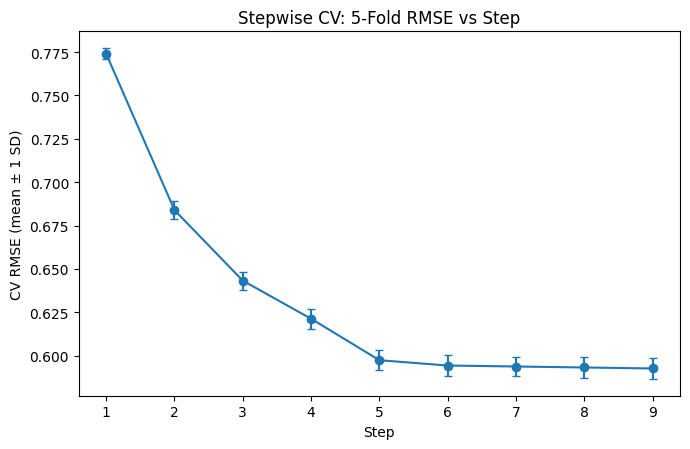

In [564]:
#| label: fig-stepwise-cv-rmse-step
#| fig-cap: "Stepwise five-fold cross-validation path showing mean RMSE (±1 SD) versus step index for log-transformed OLS models."
#| fig-width: 7
#| fig-height: 5
#| echo: false

rmse_mean = [h["mean"] for h in hist]
rmse_sd   = [h["sd"]   for h in hist]

plt.figure(figsize=(7, 4.6))
plt.errorbar(
    range(1, len(rmse_mean) + 1),
    rmse_mean,
    yerr=rmse_sd,
    marker="o",
    capsize=3
)
plt.title("Stepwise CV: 5-Fold RMSE vs Step")
plt.xlabel("Step")
plt.ylabel("CV RMSE (mean ± 1 SD)")
plt.tight_layout()
plt.show()


In [565]:
#| label: tbl-model-selection-mse
#| tbl-cap: "Stepwise five-fold cross-validation with Mean Squared Error (MSE) for candidate log-transformed OLS models."
#| echo: false

terms = [
    "temp", "hum", "windspeed",
    "C(weathersit)", "C(hr)", "C(weekday)",
    "workingday", "holiday", "C(season)", "C(yr)"
]

# Stepwise selection CV for MSE
selected, mse_mean_val, mse_sd_val, final_formula, hist = stepwise_selection_cv(
    df, "log_cnt", terms, K=5, metric="mse", tol=1e-4, max_steps=20, verbose=True
)
print("\nBest formula:", final_formula)
print("MSE:", mse_mean_val, "SD:", mse_sd_val)

ols_selected_mse = smf.ols(final_formula, data=df).fit()

Start: MSE=2.010411 (sd=0.039871) | log_cnt ~ 1
ADD  C(hr)                -> MSE=0.599285 (sd=0.005114)
ADD  temp                 -> MSE=0.467819 (sd=0.007279)
ADD  C(yr)                -> MSE=0.413770 (sd=0.006639)
ADD  C(weathersit)        -> MSE=0.386012 (sd=0.007119)
ADD  C(season)            -> MSE=0.356864 (sd=0.007008)
ADD  C(weekday)           -> MSE=0.353218 (sd=0.007165)
ADD  hum                  -> MSE=0.352542 (sd=0.006600)
ADD  windspeed            -> MSE=0.351882 (sd=0.007098)
ADD  workingday           -> MSE=0.351195 (sd=0.007287)

Best formula: log_cnt ~ C(hr) + temp + C(yr) + C(weathersit) + C(season) + C(weekday) + hum + windspeed + workingday
MSE: 0.3511951579346585 SD: 0.007286777545519475


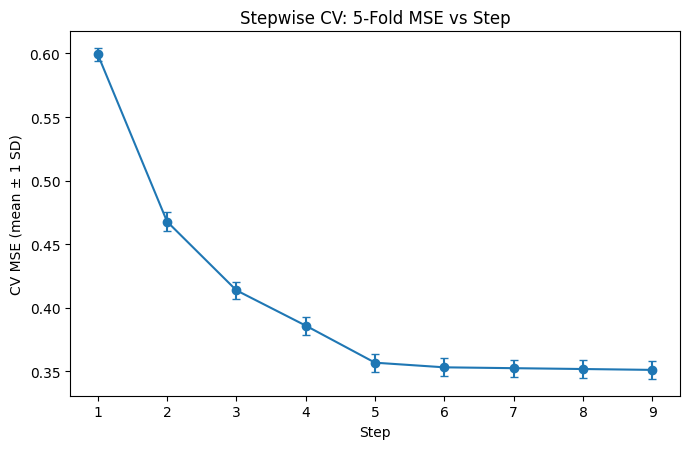

In [566]:
#| label: fig-stepwise-cv-mse-step
#| fig-cap: "Stepwise five-fold cross-validation path showing mean MSE (±1 SD) versus step index for log-transformed OLS models."
#| fig-width: 7
#| fig-height: 5
#| echo: false

mse_mean = [h["mean"] for h in hist]
mse_sd   = [h["sd"]   for h in hist]

plt.figure(figsize=(7, 4.6))
plt.errorbar(
    range(1, len(mse_mean) + 1),
    mse_mean,
    yerr=mse_sd,
    marker="o",
    capsize=3
)
plt.title("Stepwise CV: 5-Fold MSE vs Step")
plt.xlabel("Step")
plt.ylabel("CV MSE (mean ± 1 SD)")
plt.tight_layout()
plt.show()


In [567]:
#| label: tbl-model-selection-aic-bic
#| tbl-cap: "Stepwise five-fold cross-validation with BIC for candidate log-transformed OLS models."
#| echo: false

terms = [
    "temp", "hum", "windspeed",
    "C(weathersit)", "C(hr)", "C(weekday)",
    "workingday", "holiday", "C(season)", "C(yr)"
]

# Run stepwise selection for AIC/BIC
selected_terms, best_score, final_formula, history = stepwise_selection_aic_bic(
    df=df,
    y="log_cnt",
    candidate_terms=terms,
    criterion="bic",   # or "aic"
    verbose=True
)
print("\nBest formula:", final_formula)
print("\nScore:", best_score)
ols_selected_aic_bic = smf.ols(final_formula, data=df).fit()



Start: BIC=61464.164802 | log_cnt ~ 1
ADD  C(hr)                -> BIC=40593.280281
ADD  temp                 -> BIC=36299.400639
ADD  C(yr)                -> BIC=34178.461775
ADD  C(weathersit)        -> BIC=32991.065329
ADD  C(season)            -> BIC=31652.933488
ADD  C(weekday)           -> BIC=31523.283631
ADD  hum                  -> BIC=31495.422792
ADD  windspeed            -> BIC=31469.720397
ADD  workingday           -> BIC=31444.832698

Best formula: log_cnt ~ C(hr) + temp + C(yr) + C(weathersit) + C(season) + C(weekday) + hum + windspeed + workingday

Score: 31444.83269754891


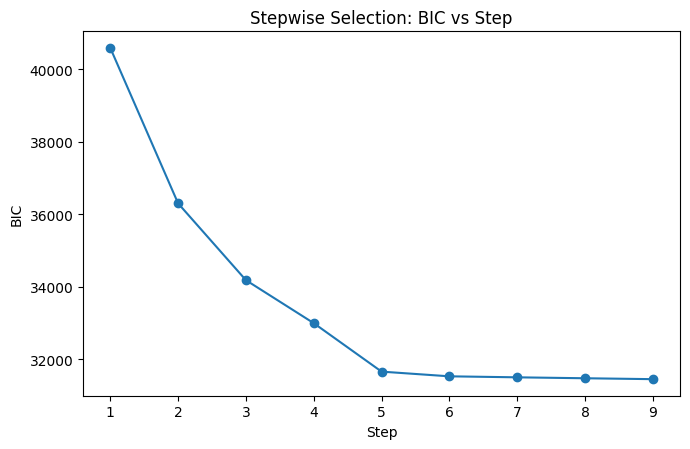

In [568]:
#| label: fig-stepwise-bic-step
#| fig-cap: "Stepwise selection path showing Bayesian Information Criterion (BIC) versus step index for log-transformed OLS models."
#| fig-width: 7
#| fig-height: 5
#| echo: false

scores = [h["score"] for h in history]

plt.figure(figsize=(7, 4.6))
plt.plot(range(1, len(scores) + 1), scores, marker="o")
plt.title("Stepwise Selection: BIC vs Step")
plt.xlabel("Step")
plt.ylabel("BIC")
plt.tight_layout()
plt.show()

Our model selection was performed using **stepwise 5-fold cross-validation (CV) with RMSE** as the selection criterion as mentioned in section III.3 and shown in @tbl-model-selection-rmse and @fig-stepwise-cv-rmse-step. Given the size of the dataset, 5-fold CV was adequate for our analysis within considerations for time and resources. The motivation for using RMSE is that CV RMSE directly **evaluates out-of-sample predictive performance** compared to AIC/BIC and better for interpretation than MSE with the same penalization for outliers. Unlike likelihood-based criteria (AIC/BIC), CV RMSE makes minimal assumptions and provides a robust assessment of **generalization error** especially in the presence of correlated predictors and large sample sizes.

In the stepwise selection logs for RMSE in @tbl-model-selection-rmse and depicted in @fig-stepwise-cv-rmse-step, significant reductions in error were observed when adding core time and weather-related predictors (C(hr), temp, C(yr), C(weathersit), and C(season)). However, beyond these core predictors, additional predictors produced only **marginal improvements in RMSE**, with reductions within one standard deviation of the CV estimates. This flattening or convergence of the RMSE curve (~0.592-0.597) shows a **diminishing predictive returns** and led us to a selection of a reduced model that balanced **predictive accuracy with minimal complexity for interpretation**.

Among these, one key observation was the **complete exclusion of the holiday predictor** while retaining both weekday and workingday. These specifications could highlight the value of preserving some relevant calendar and weather structures while eliminating weak or redundant predictors like hum, windspeed, and workingday, without sacrificing out-of-sample predictive performance.

Lastly, we also experimented with stepwise 5-fold cross-validation with MSE and BIC as shown in @tbl-model-selection-mse and @tbl-model-selection-aic-bic. Overall, both experiments (MSE and BIC) were **consistent with the same observations** as mentioned above. Criterion scores begin to converge (MSE: ~0.351-0.353 / BIC: ~31,444-31,523) after adding C(hr), temp, C(yr), C(weathersit), and C(season) with minimal additional benefit from including remaining variables.

## Compare selected models vs. baseline

In [569]:
#| label: tbl-model-selection-analysis-in-sample
#| tbl-cap: "In-sample evaluation for Baseline vs. Selected OLS model for log cnt using Adjusted R^2, AIC, and BIC."
#| echo: false

final_selection = dedent("""
log_cnt ~ temp
    + C(weathersit)
    + C(hr)
    + C(season)
    + C(yr)
""").strip()
ols_selected = smf.ols(final_selection, data=df).fit()

pd.DataFrame({
    "Model": ["Baseline log OLS", "Selected model"],
    "Adj_R^2": [ols_log.rsquared_adj, ols_selected.rsquared_adj],
    "AIC": [ols_log.aic, ols_selected.aic],
    "BIC": [ols_log.bic, ols_selected.bic],
})

,Model,Adj_R^2,AIC,BIC
0,Baseline log OLS,0.825786,31127.080796,31445.364528
1,Selected model,0.822891,31404.516917,31652.933488


In [570]:
#| label: tbl-model-selection-analysis-out-of-sample
#| tbl-cap: "CV RMSE evaluation for selected OLS model for log cnt."
#| echo: false

terms_selected = [
    "temp",
    "C(weathersit)", "C(hr)", 
    "C(season)", "C(yr)"
]

# Stepwise selection CV for RMSE with ols_selected
selected, mean_rmse_selected, sd_rmse_selected, final_formula, hist = stepwise_selection_cv(
    df, "log_cnt", terms_selected, K=5, metric="rmse", tol=1e-4, max_steps=20, verbose=True
)

print("RMSE:", mean_rmse_selected, "SD:", sd_rmse_selected)

Start: RMSE=1.417834 (sd=0.014040) | log_cnt ~ 1
ADD  C(hr)                -> RMSE=0.774129 (sd=0.003304)
ADD  temp                 -> RMSE=0.683957 (sd=0.005311)
ADD  C(yr)                -> RMSE=0.643233 (sd=0.005164)
ADD  C(weathersit)        -> RMSE=0.621278 (sd=0.005742)
ADD  C(season)            -> RMSE=0.597358 (sd=0.005879)
RMSE: 0.5973581846445841 SD: 0.0058789993280516616


The reduced/selected model, where the variables with negligible out-of-sample CV RMSE improvements were excluded, was compared to the baseline log-transformed OLS model using both in-sample metrics (adjusted R^2, AIC, and BIC) and out-of-sample CV RMSE. The in-sample comparison is shown in @tbl-model-selection-analysis-in-sample, whereas the CV RMSE comparison is presented in @tbl-model-selection-rmse and @tbl-model-selection-analysis-out-of-sample, as discussed in section IV.3. 

The adjusted R^2 of the selected model slightly lower than the baseline model, reflecting the intentional removal of predictors. However, the difference is small, showing that the **reduced model retains most of the explanatory power with fewer predictors**. This is expected since adjusted R^2 penalizes complexity minimally and, as a result, not designed as a primary model selection criterion.

Both the AIC and BIC increased for the reduced model. This indicates a preference for the larger baseline model under likelihood-based criteria. While this was initially surprising since we expected BIC to penalize complexity heavily, it is likely driven by the large sample size because **small improvements in log-likelihood over many observations can outweigh the complexity penalty** especially for predictors with subtle but detectable effects.

Most importantly, this does not contradict our CV RMSE findings. AIC and BIC evaluate goodness-of-fit through the lens of likelihood i.e., goodness-of-fit to observed data, whereas CV RMSE evaluates predictive stability on unseen data. Our findings highlight a **modeling trade-off** between likelihood criteria that favor richer models in large samples, while CV emphasizes gains in predictive performance. In our case, our decision for the reduced model prioritizes generalization performance over marginal in-sample improvements and avoids over-interpreting weak effects or collinearity among time and calendar-related predictors.

In the next section, we'll explore regularization techniques that may allow all predictors to remain in the baseline model while shrinking correlated coefficients toward each other or possibly shrinking the same weaker variables that we removed to zero as part of feature selection.

# Ridge and Lasso Regression

## Ridge Regression

In [571]:
#| label: tbl-ridge-cv-results
#| tbl-cap: "Ridge regression: cross-validated selection of the regularization parameter (alpha) and predictive performance."
#| echo: false

# Redefine y and X for log-transformed baseline
y, X = patsy.dmatrices(
    log_formula,
    data=df,
    return_type="dataframe"
)
# Flatten y
y_vec = y.values.ravel()
# Drop intercept
X_no_intercept = X.drop(columns="Intercept")
# Drop headers
Xmat = Xmat = X_no_intercept.values

# Define alpha log space for Ridge
alphas_ridge = np.logspace(-4, 4, 100)

# Pipeline with standardization for 5-fold
pipe_ridge = Pipeline([
    ("scaler", StandardScaler()),
    ("ridgecv", RidgeCV(alphas=alphas_ridge, cv=5, scoring="neg_mean_squared_error"))
])
# Fit regression
pipe_ridge.fit(X_no_intercept, y_vec)

# Print
best_alpha_ridge = float(pipe_ridge.named_steps["ridgecv"].alpha_)
print("Ridge Regression with 5-fold CV selection")
print("Best ridge alpha:", best_alpha_ridge)

Ridge Regression with 5-fold CV selection
Best ridge alpha: 54.62277217684348


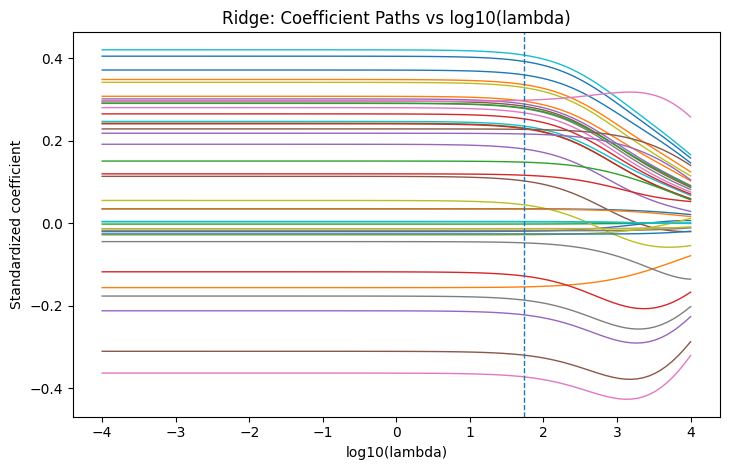

In [572]:
#| label: fig-ridge-coefficient-path
#| fig-cap: "Ridge regression coefficient paths showing standardized coefficients as a function of log10(λ), with the dashed line indicating the cross-validated optimal regularization parameter."
#| fig-width: 7
#| fig-height: 5
#| echo: false

# Standardize X
scaler = StandardScaler()
Xstd = scaler.fit_transform(X_no_intercept.values)  # (n, p)

# Use the same alpha grid
alphas_path = alphas_ridge  #

# Fit ridge across the path and collect coefficients
coefs = []
for a in alphas_path:
    m = Ridge(alpha=a, fit_intercept=False) 
    m.fit(Xstd, y_vec)
    coefs.append(m.coef_)
coefs = np.array(coefs)  # (n_alphas, p)

# Plot coefficient paths
plt.figure(figsize=(7.4, 4.8))
for j in range(coefs.shape[1]):
    plt.plot(np.log10(alphas_path), coefs[:, j], linewidth=1)

plt.axvline(np.log10(best_alpha_ridge), linestyle="--", linewidth=1)
plt.title("Ridge: Coefficient Paths vs log10(lambda)")
plt.xlabel("log10(lambda)")
plt.ylabel("Standardized coefficient")
plt.tight_layout()
plt.show()


## Lasso regression

In [573]:
#| label: tbl-lasso-cv-results
#| tbl-cap: "Lasso regression: cross-validated selection of the regularization parameter (alpha) and predictive performance."
#| echo: false

# Feature names corresponding to Xmat columns
predictors = list(X_no_intercept.columns)

# Define a grid of candidate regularization parameters (alpha) on a log scale.
alphas_lasso = np.logspace(-4, 4, 100)

# Configure Lasso with K-fold cross-validation.
# - alphas: grid of candidate alpha values
# - cv: number of folds
# - random_state: reproducibility
# - max_iter: ensure convergence for high-dimensional designs
lasso_cv = LassoCV(
    alphas=alphas_lasso,
    cv=5,
    random_state=42,
    max_iter=20000
)

# Build a pipeline that:
# 1) standardizes predictors (required for Lasso),
# 2) fits LassoCV on the standardized design matrix.
pipe_lasso = Pipeline([
    ("scaler", StandardScaler()),
    ("lassocv", lasso_cv)
])

# Fit the pipeline to the design matrix Xmat and response y_vec.
# Cross-validation is performed internally by LassoCV.
pipe_lasso.fit(Xmat, y_vec)

# Extract the alpha that minimizes mean cross-validated MSE.
# This is sklearn's default choice (alpha_min).
alpha_min = float(pipe_lasso.named_steps["lassocv"].alpha_)

# Alias the fitted LassoCV object for convenience.
lassocv = pipe_lasso.named_steps["lassocv"]

# Extract the cross-validated MSE path:
# - mse_path_: matrix of shape (n_alphas, n_folds)
# - alphas_: corresponding alpha values (typically in descending order)
mse_path = lassocv.mse_path_        # (n_alphas, n_folds)
alphas_cv = lassocv.alphas_         # descending order

# Compute mean CV MSE and its standard error across folds for each alpha.
# These quantities are required to implement the 1-SE rule.
mean_mse = mse_path.mean(axis=1)
se_mse = mse_path.std(axis=1, ddof=1) / np.sqrt(mse_path.shape[1])

# Identify the index of the minimum mean CV MSE.
min_idx = int(np.argmin(mean_mse))

# Compute the 1-SE threshold: mean MSE at alpha_min plus one standard error.
threshold = float(mean_mse[min_idx] + se_mse[min_idx])

# Identify all alphas whose mean CV MSE is within 1 SE of the minimum.
# The 1-SE rule selects the LARGEST alpha in this set
# (i.e., the most regularized model within statistical tolerance).
candidate_idxs = np.where(mean_mse <= threshold)[0]
alpha_1se = float(alphas_cv[candidate_idxs[0]])

# Fit lasso at alpha_1se (1-SE rule) and extract coefficients
lasso_1se = Pipeline([
    ("scaler", StandardScaler()),
    ("lasso", Lasso(alpha=alpha_1se, max_iter=20000))
])
lasso_1se.fit(Xmat, y_vec)
coef_1se = lasso_1se.named_steps["lasso"].coef_


# Report key quantities for interpretation and comparison.
print("Lasso Regression with 5-fold CV selection")
print("alpha_min:", alpha_min)
print("alpha_1se:", alpha_1se)
print("min mean MSE:", float(mean_mse[min_idx]))
print("1-SE threshold:", threshold)

Lasso Regression with 5-fold CV selection
alpha_min: 0.0009326033468832199
alpha_1se: 0.010476157527896652
min mean MSE: 0.3698843993068294
1-SE threshold: 0.3898582268015863


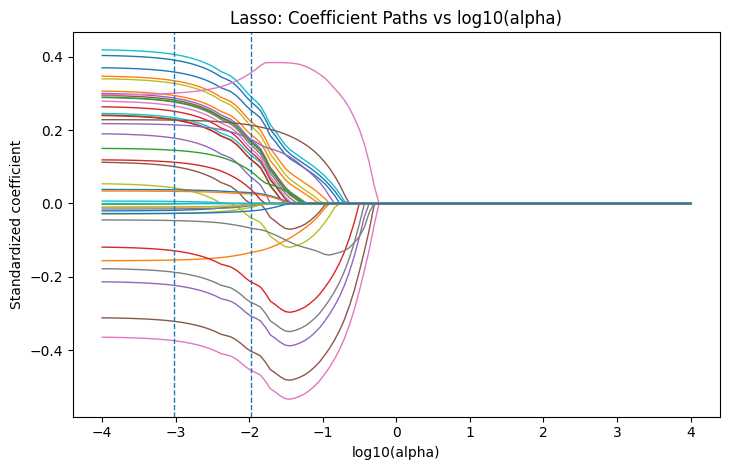

In [574]:
#| label: fig-lasso-coefficient-path
#| fig-cap: "Lasso coefficient paths showing standardized coefficients as a function of log10(alpha), with dashed lines indicating alpha_min (minimum CV error) and alpha_1se (one-standard-error rule)."
#| fig-width: 7
#| fig-height: 5
#| echo: false

# Standardize X so coefficients are on a comparable scale.
# This is essential because the L1 penalty is scale-dependent.
Xstd = StandardScaler().fit_transform(Xmat)

# Define a smooth grid of alpha values spanning alphas_lasso.
# Using a dense grid makes the coefficient paths visually smooth.
alphas_lp = np.logspace(
    np.log10(alphas_lasso.min()),
    np.log10(alphas_lasso.max()),
    120
)

# Compute lasso coefficient paths across the alpha grid.
alphas_out, coef_path, _ = lasso_path(Xstd, y_vec, alphas=alphas_lp, max_iter=20000)

# Plot using the returned alphas (which match coef_path columns)
plt.figure(figsize=(7.4, 4.8))
for j in range(coef_path.shape[0]):
    plt.plot(np.log10(alphas_out), coef_path[j, :], linewidth=1)

plt.axvline(np.log10(alpha_min), linestyle="--", linewidth=1)
plt.axvline(np.log10(alpha_1se), linestyle="--", linewidth=1)

plt.title("Lasso: Coefficient Paths vs log10(alpha)")
plt.xlabel("log10(alpha)")
plt.ylabel("Standardized coefficient")
plt.tight_layout()
plt.show()



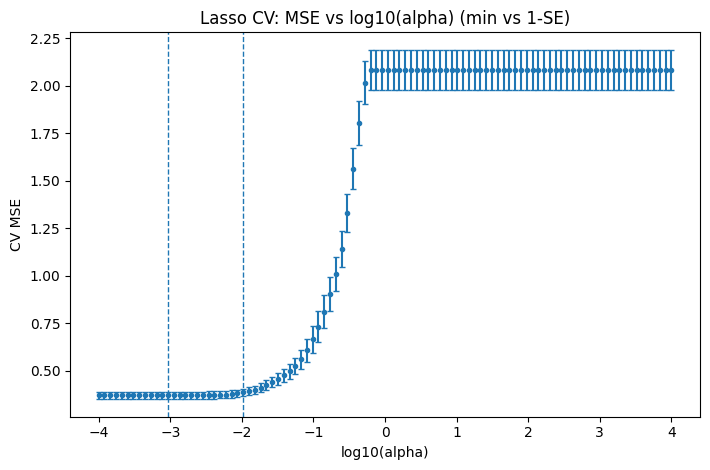

In [575]:
#| label: fig-lasso-cv-curve
#| fig-cap: "Lasso cross-validation curve showing mean CV MSE (±1 SE) as a function of log10(alpha), with dashed lines indicating alpha_min and alpha_1se."
#| fig-width: 7
#| fig-height: 5
#| echo: false

plt.figure(figsize=(7.2, 4.8))
plt.errorbar(
    np.log10(alphas_cv),
    mean_mse,
    yerr=se_mse,
    fmt="o",
    markersize=3,
    capsize=2
)

plt.axvline(np.log10(alpha_min), linestyle="--", linewidth=1)
plt.axvline(np.log10(alpha_1se), linestyle="--", linewidth=1)

plt.title("Lasso CV: MSE vs log10(alpha) (min vs 1-SE)")
plt.xlabel("log10(alpha)")
plt.ylabel("CV MSE")
plt.tight_layout()
plt.show()


In [576]:
#| label: tbl-lasso-selection-comparison
#| tbl-cap: "Comparison of predictors selected by lasso regression under the minimum cross-validated error rule (alpha_min) and the one-standard-error rule (alpha_1se). For each model, retained predictors and their corresponding coefficients are shown; blank cells indicate predictors not selected under the given regularization level."
#| echo: false

# Coefficients at alpha_min (from LassoCV)
coef_min_s = pd.Series(
    pipe_lasso.named_steps["lassocv"].coef_,
    index=predictors
)

df_min = (
    coef_min_s[coef_min_s != 0]
    .sort_values(key=np.abs, ascending=False)
    .rename("coef")
    .reset_index()
    .rename(columns={"index": "predictor"})
)

# Coefficients at alpha_1se (from refit lasso_1se)
coef_1se_s = pd.Series(coef_1se, index=predictors)

df_1se = (
    coef_1se_s[coef_1se_s != 0]
    .sort_values(key=np.abs, ascending=False)
    .rename("coef")
    .reset_index()
    .rename(columns={"index": "predictor"})
)

# Pad shorter dataframe with blanks so rows align
max_len = max(len(df_min), len(df_1se))
df_min_pad = df_min.reindex(range(max_len))
df_1se_pad = df_1se.reindex(range(max_len))

# Final comparison table
table = pd.DataFrame({
    "Predictor (alpha_min)": df_min_pad["predictor"],
    "Coefficient (alpha_min)": df_min_pad["coef"],
    "Predictor (alpha_1se)": df_1se_pad["predictor"],
    "Coefficient (alpha_1se)": df_1se_pad["coef"],
})

table

,Predictor (alpha_min),Coefficient (alpha_min),Predictor (alpha_1se),Coefficient (alpha_1se)
0,C(hr)[T.17],0.406811,C(hr)[T.4],-0.455284
1,C(hr)[T.18],0.391467,C(hr)[T.3],-0.402966
2,C(hr)[T.4],-0.374228,temp,0.356028
3,C(hr)[T.8],0.358817,C(hr)[T.2],-0.306849
4,C(hr)[T.19],0.335117,C(hr)[T.17],0.291569
5,C(hr)[T.16],0.327749,C(hr)[T.18],0.277849
6,C(hr)[T.3],-0.321401,C(hr)[T.5],-0.269552
7,temp,0.300879,C(hr)[T.8],0.254554
8,C(hr)[T.9],0.294801,C(hr)[T.19],0.223850
9,C(hr)[T.12],0.287836,C(hr)[T.1],-0.213825


In [577]:
#| label: tbl-lasso-zeroed-out-comparison
#| tbl-cap: "Predictors shrunk to zero by lasso under the minimum cross-validated error rule (alpha_min) and the one-standard-error rule (alpha_1se)."
#| echo: false

# Coefficient series for each fitted model
coef_min_s = pd.Series(pipe_lasso.named_steps["lassocv"].coef_, index=predictors)
coef_1se_s = pd.Series(coef_1se, index=predictors)

# Identify zeroed-out predictors (exact zeros from sklearn)
zero_min = coef_min_s[coef_min_s == 0].index.tolist()
zero_1se = coef_1se_s[coef_1se_s == 0].index.tolist()

# Sort for readability
zero_min = sorted(zero_min)
zero_1se = sorted(zero_1se)

# Pad shorter list with blanks so both columns align
max_len = max(len(zero_min), len(zero_1se))

table_zero = pd.DataFrame({
    "Zeroed out (alpha_min)": zero_min + [""] * (max_len - len(zero_min)),
    "Zeroed out (alpha_1se)": zero_1se + [""] * (max_len - len(zero_1se)),
})

table_zero


,Zeroed out (alpha_min),Zeroed out (alpha_1se)
0,workingday,C(hr)[T.23]
1,,C(weathersit)[T.4]
2,,C(weekday)[T.4]
3,,workingday


## Selected OLS vs. Ridge vs. Lasso comparison

In [578]:
# Setup sklearn RMSE CV for patsy design matrix
def cv_rmse_sklearn(model, X, y, K=5, random_state=42):
    kf = KFold(n_splits=K, shuffle=True, random_state=random_state)
    rmses = []

    for tr, te in kf.split(X):
        model.fit(X[tr], y[tr])
        preds = model.predict(X[te])
        rmses.append(np.sqrt(mean_squared_error(y[te], preds)))

    return float(np.mean(rmses)), float(np.std(rmses, ddof=1))

In [579]:
# Ridge at best alpha
ridge_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Ridge(alpha=best_alpha_ridge))
])

# Lasso at alpha_min (minimum CV error)
lasso_min_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Lasso(alpha=alpha_min, max_iter=20000))
])

# Lasso at alpha_1se (1-SE rule, more regularized)
lasso_1se_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Lasso(alpha=alpha_1se, max_iter=20000))
])

# Calculate RMSE for Ridge, Lasso (alpha_min), and Lasso (alpha_1se)
ridge_rmse_mean, ridge_rmse_sd = cv_rmse_sklearn(
    ridge_pipe, Xmat, y_vec, K=5, random_state=42
)

lasso_min_rmse_mean, lasso_min_rmse_sd = cv_rmse_sklearn(
    lasso_min_pipe, Xmat, y_vec, K=5, random_state=42
)

lasso_1se_rmse_mean, lasso_1se_rmse_sd = cv_rmse_sklearn(
    lasso_1se_pipe, Xmat, y_vec, K=5, random_state=42
)

In [580]:
#| label: tbl-model-comparison-regularization
#| tbl-cap: "Comparison of selected OLS, ridge, and lasso models based on cross-validated predictive performance and regularization characteristics, including the one-standard-error (1-SE) lasso solution."
#| echo: false

# Comparison Table setup
comparison_df = pd.DataFrame({
    "Model": ["Selected OLS", "Ridge", "Lasso (alpha_min)", "Lasso (alpha_1se)"],
    "Selected alpha": ["—", best_alpha_ridge, alpha_min, alpha_1se],
    "CV RMSE (mean)": [
        mean_rmse_selected,
        ridge_rmse_mean,
        lasso_min_rmse_mean,
        lasso_1se_rmse_mean
    ],
    "CV RMSE (SD)": [
        sd_rmse_selected,
        ridge_rmse_sd,
        lasso_min_rmse_sd,
        lasso_1se_rmse_sd
    ],
})

comparison_df


,Model,Selected alpha,CV RMSE (mean),CV RMSE (SD)
0,Selected OLS,—,0.597358,0.005879
1,Ridge,54.622772,0.592777,0.006014
2,Lasso (alpha_min),0.000933,0.592737,0.005986
3,Lasso (alpha_1se),0.010476,0.607567,0.005406


In this section (V), we explore Ridge and Lasso regularization techniques intended to **improve generalization in the presence of predictors with strong collinearity**. By penalizing large coefficients and reducing variance, regularization stabilizes estimates of correlated predictors (e.g., many encoded hour (hr) or categorical predictors). Additionally, it provides a bias-variance tradeoff that could help ensure a balance in-sample fit to reliable out-of-sample predictive performance. Both regularization techniques were **performed on the baseline log transformed OLS model** before reduction in predictors.

In @tbl-ridge-cv-results, we leveraged a 5-fold CV to select a near optimal regularization parameter (alpha = 54.62) while taking advantage of the Ridge squared coefficient penalty that shrinks them toward zero while **sharing weights across correlated predictors without removing any** as shown in @fig-ridge-coefficient-path.

Similarly, in @tbl-lasso-cv-results, two regularization parameters (alpha_min and alpha_1se) were derived using 5-fold cross-validation with MSE as the natural loss function. The alpha_min value selects the model that minimizes mean CV MSE, thereby **maximizing predictive accuracy**. In contrast, alpha_1se, defined as the largest regularization parameter whose mean CV MSE lies within one standard error of the minimum, is designed to **favor simpler and more stable models without a meaningful loss in predictive accuracy**.

As shown in @fig-lasso-coefficient-path and @fig-lasso-cv-curve, increasing the regularization strength leads to **progressive coefficient shrinkage and variable elimination**. The alpha_min model retains more predictors, with only one coefficient (workingday) shrunk exactly to zero, whereas the alpha_1se model applies stronger regularization and collapses four predictors to zero, as confirmed in @tbl-lasso-selection-comparison and @tbl-lasso-zeroed-out-comparison. Together, these visuals illustrate the impact of increasing regularization on both predictive error (MSE) and coefficient sparsity.

Overall, @tbl-model-comparison-regularization supports the following conclusions:
1) In comparison to our reduced/selected log-transformed OLS model (Selected OLS in @fig-lasso-coefficient-path), we observe **marginal improvements of approximately 0.005 RMSE** in Ridge and Lasso (alpha_min). Differences in RMSE are small relative to their SDs with **no meaningful separation in predictive accuracy**. Regularization helps modestly, but predictive performance is not the main differentiator
2) However, in terms of interpretability, Lasso (alpha_1se) removed four predictors and produced a substantially **sparser and more interpretable model**, at the cost of a small RMSE increase
3) Lastly, in terms of regularization effects on collinearity, Ridge effectively shrank correlated coefficients together (e.g, the many correlated categorical predictors like C(hr)) **without removing any predictors**

# Conclusion

## Summary of findings

This project analyzed hourly bike-sharing demand using a combination of exploratory analysis, classical regression, and regularized models to **balance predictive accuracy, interpretability, and stability**. The goal was to identify key drivers for hourly bike rentals across a high-dimensional feature space dominated by categorical temporal and weather predictors.

Across all models, the time of day or hour emerged the strongest predictor of bike rental demand, reflecting clear commuting and leisure patterns. Temperature showed a significant positive association, while weather conditions and seasonal effects contributed secondary but meaningful adjustments. With time of day effects include, several calendar variables like workingday, weekday, or holiday provided limited additional explanatory power, likely due to redundancy among correlated predictors.

From a predictive accuracy standpoint, the reduced OLS, Ridge, and Lasso (alpha_min) achieved nearly identical CV RMSE. This highlights the fact that prediction alone does not fully justify regularization in this case. However, the **primary value of regularization was seen in stability and interpretability**. By applying the 1-SE rule to Lasso, our feature selection produced a substantially sparser model with little loss in RMSE, while improving interpretability.

In conclusion, the results show that bike-sharing demand is strongly associated to temporal structure and weather-related factors.